<a href="https://colab.research.google.com/github/OliviaXu312/ANLY590/blob/master/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets
from keras.utils import to_categorical
from keras.datasets import cifar10

tfkl = tfk.layers

# Q1 Autoencoder

## Load Data

In [2]:
data, info = tfds.load('cifar10', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteVPCMEJ/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteVPCMEJ/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])

ds_train = data['train'].map(preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
ds_test = data["test"].map(preprocess)

In [4]:
#test_labels = tf.one_hot(test_labels.astype(np.int32), depth = 10)

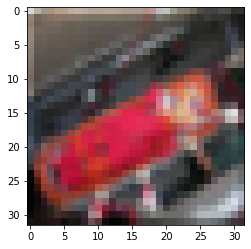

In [6]:
x, y = next(iter(ds_train))
plt.imshow(x[10,:,:,:])

## Convolutional Autoencoder Model

In [7]:
img_shape = info.features['image'].shape
img_shape

(32, 32, 3)

In [9]:
encoder = tfk.Sequential([
              tfkl.InputLayer(img_shape),
              tfkl.Conv2D(filters = 64, kernel_size=3, strides=1, 
                          padding="same", activation='relu'),
              tfkl.MaxPool2D(pool_size = 2),
              tfkl.Dropout(0.2),

              tfkl.Conv2D(filters = 32, kernel_size=3, strides=1,
                      padding="same", activation='relu'),
              tfkl.MaxPool2D(pool_size = 2),
              tfkl.Dropout(0.2),

              tfkl.Conv2D(filters = 16, kernel_size=3, strides=1, 
                      padding="same", activation='relu'),
              tfkl.MaxPool2D(pool_size = 2)            
])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)         

In [10]:
decoder = tfk.Sequential([
              tfkl.InputLayer((4, 4, 16)),
              tfkl.Conv2D(filters = 16, kernel_size=3, strides=1, 
                      padding="same", activation='relu'),
              tfkl.UpSampling2D(size = 2),

              tfkl.Conv2D(filters = 32, kernel_size=3, strides=1,
                      padding="same", activation='relu'),
              tfkl.UpSampling2D(size = 2),

              tfkl.Conv2D(filters = 64, kernel_size=3, strides=1,
                      padding="same", activation='relu'),
              tfkl.UpSampling2D(size = 2),

              tfkl.Conv2D(filters = 3, kernel_size=3,
                           padding="same", activation='sigmoid')
              ])

decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 4, 4, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 3)        

In [11]:
x = tfkl.Input(img_shape)

h = encoder(x)
xhat = decoder(h)

autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)

results = autoencoder.fit(ds_train, steps_per_epoch=100, epochs=10)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 4, 4, 16)          24880     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         27187     
Total params: 52,067
Trainable params: 52,067
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 21s 209ms/step - loss: 0.6358
Epoch 2/10
100/100 [==============================] - 21s 209ms/step - loss: 0.5997
Epoch 3/10
100/100 [==============================] - 21s 212ms/step - loss: 0.5912
Epoch 4/10
100/100 [==============================] - 21s 209ms/step - loss: 0.5856
Epoch 5/10
100/100 [========================

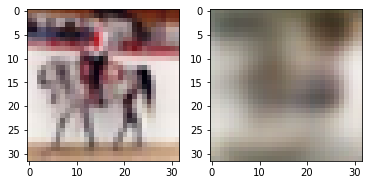

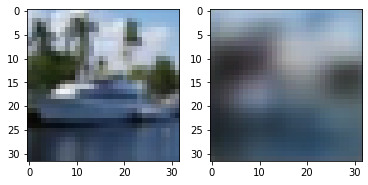

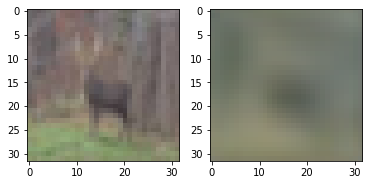

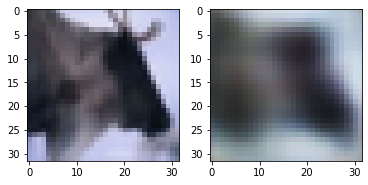

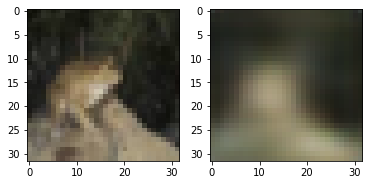

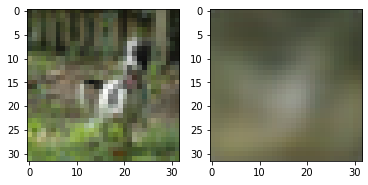

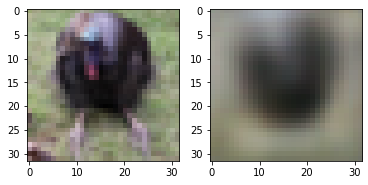

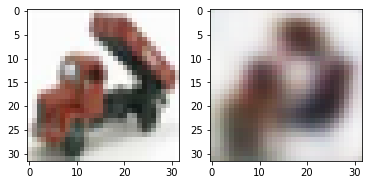

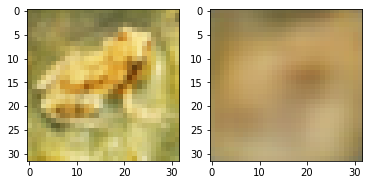

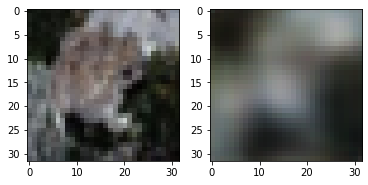

In [12]:
imgs = next(iter(ds_train))[0]
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
    plt.subplot(1, 2, 2, )
    plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
    plt.show()

## Q2.1 Deep CNN

In [15]:
model1 = tfk.Sequential()
model1.add(tfkl.Conv2D(64,kernel_size=(3,3),strides=1,input_shape=(32,32,3),padding='valid',activation='relu'))
model1.add(tfkl.MaxPool2D(pool_size=(2,2)))
model1.add(tfkl.Dropout(0.3))
model1.add(tfkl.Conv2D(32,kernel_size=(3,3),strides=1,padding='valid',activation='relu'))
model1.add(tfkl.MaxPool2D(pool_size=(2,2)))
model1.add(tfkl.Dropout(0.3))
model1.add(tfkl.Flatten())
model1.add(tfkl.Dense(64,activation='relu'))
model1.add(tfkl.Dropout(0.5))
model1.add(tfkl.Dense(10,activation='softmax'))
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [25]:
model1.compile(optimizer=tfk.optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = (x_train/255).astype('float32')
x_test = (x_test/255).astype('float32')

train_label = to_categorical(y_train)
test_label = to_categorical(y_test)
results2 = model1.fit(x_train,train_label,steps_per_epoch=100,epochs=20,batch_size=16,validation_data=(x_test,test_label))

Epoch 1/20
100/100 [==============================] - 10s 105ms/step - loss: 2.3029 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/20
100/100 [==============================] - 7s 74ms/step - loss: 2.3025 - accuracy: 0.1044 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/20
100/100 [==============================] - 7s 75ms/step - loss: 2.3032 - accuracy: 0.1063 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/20
100/100 [==============================] - 7s 74ms/step - loss: 2.3030 - accuracy: 0.0887 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
100/100 [==============================] - 8s 79ms/step - loss: 2.3025 - accuracy: 0.1063 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/20
100/100 [==============================] - 8s 77ms/step - loss: 2.3026 - accuracy: 0.1037 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/20
100/100 [==============================] - 8s 79ms/step - loss: 2.3031 - accuracy: 0.1063 - val_loss: 2.3027 - val_accuracy: 0.10

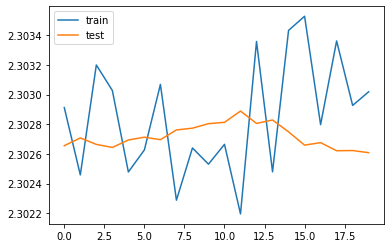

In [26]:
plt.plot(results2.history['loss'])
plt.plot(results2.history['val_loss'])
plt.legend(labels=['train','test'])

# Q2.2 Transfer Learning

In [27]:
from tensorflow.keras.applications import VGG16

In [32]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
conv_base.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [33]:
modeltransfer = tfk.Sequential()
modeltransfer.add(conv_base)
modeltransfer.add(tfkl.Flatten())
modeltransfer.add(tfkl.Dense(64, activation='relu'))
modeltransfer.add(tfkl.Dropout(0.5))
modeltransfer.add(tfkl.Dense(10, activation='softmax'))
modeltransfer.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 14,748,170
Non-trainable params: 0
_________________________________________________________________


In [34]:
conv_base.trainable = False
len(modeltransfer.trainable_weights)

4

In [36]:
modeltransfer.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = modeltransfer.fit(x_train, train_label, epochs=5, batch_size=32,validation_data=(x_test,test_label))


Epoch 1/5
1563/1563 [==============================] - 650s 416ms/step - loss: 1.6679 - accuracy: 0.4122 - val_loss: 1.3692 - val_accuracy: 0.5221
Epoch 2/5
1563/1563 [==============================] - 649s 415ms/step - loss: 1.4650 - accuracy: 0.4908 - val_loss: 1.3085 - val_accuracy: 0.5470
Epoch 3/5
1563/1563 [==============================] - 648s 414ms/step - loss: 1.4222 - accuracy: 0.5118 - val_loss: 1.2882 - val_accuracy: 0.5520
Epoch 4/5
1563/1563 [==============================] - 648s 414ms/step - loss: 1.4080 - accuracy: 0.5217 - val_loss: 1.3000 - val_accuracy: 0.5491
Epoch 5/5
1563/1563 [==============================] - 649s 415ms/step - loss: 1.4002 - accuracy: 0.5263 - val_loss: 1.2802 - val_accuracy: 0.5640


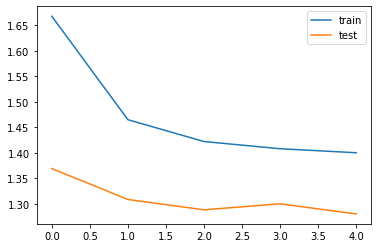

In [37]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(labels=['train','test'])

# Q3. Text Classification
## Q3.1 RNN

In [76]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
import re
from keras.models import Sequential

In [40]:
from google.colab import drive

drive.mount('/content/gdrive/')

df = pd.read_csv("/content/gdrive/My Drive/anly590-datasets/SPAM_detection.csv")
df.head()

Mounted at /content/gdrive/


,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [48]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [50]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
word_index = tokenizer.word_index
print("unique number of tokens")
print(len(word_index))

unique number of tokens
9006


In [51]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Number of text tensor')
print(X.shape)

Number of text tensor
(5572, 250)


In [53]:
y = pd.get_dummies(df['category_val']).values
print( y.shape)

(5572, 2)


In [61]:
modellstm = Sequential()
modellstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
modellstm.add(SpatialDropout1D(0.2))
modellstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modellstm.add(Dense(2, activation='softmax'))
modellstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modellstm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 919)
modellstm.fit(X_train, y_train, epochs=50, batch_size=64,validation_split=0.3)

Epoch 1/50
43/43 [==============================] - 34s 790ms/step - loss: 0.3208 - accuracy: 0.8905 - val_loss: 0.1063 - val_accuracy: 0.9821
Epoch 2/50
43/43 [==============================] - 33s 774ms/step - loss: 0.0673 - accuracy: 0.9832 - val_loss: 0.0412 - val_accuracy: 0.9880
Epoch 3/50
43/43 [==============================] - 36s 848ms/step - loss: 0.0297 - accuracy: 0.9923 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 4/50
43/43 [==============================] - 33s 770ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.0426 - val_accuracy: 0.9923
Epoch 5/50
43/43 [==============================] - 33s 771ms/step - loss: 0.0108 - accuracy: 0.9974 - val_loss: 0.0367 - val_accuracy: 0.9897
Epoch 6/50
43/43 [==============================] - 33s 765ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0457 - val_accuracy: 0.9880
Epoch 7/50
43/43 [==============================] - 33s 766ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0521 - val_accuracy: 0.9872

In [66]:
_, acc = modellstm.evaluate(X_test, y_test, verbose=0)
print(acc)

0.9838516712188721


## Q3.2 CNN

In [67]:
from tensorflow.keras.layers import Conv1D, Convolution1D, GlobalMaxPooling1D, MaxPooling1D, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence

In [68]:
docs = []
sentences = []

for sentences in df.Message:
    sentences_cleaned = [sent.lower() for sent in sentences]
    docs.append(sentences_cleaned)


In [69]:
txt = ''
for doc in docs:
    for s in doc:
        txt += s
chars = set(txt)
vocab_size = len(chars)
print("Total number of chars")
print(len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total number of chars
90


In [70]:
maxlen = 1000 
nb_filter = 8
dense_outputs = 1000
filter_kernels = [64, 64, 32, 32, 8, 8]

In [72]:
X = []
for sentences in docs:
    x = [char_indices[w] for w in sentences]
    X.append(x)
total_char = pad_sequences(X, maxlen=maxlen)

In [74]:
total_label = pd.get_dummies(df['category_val']).values
X_train, X_test, y_train, y_test = train_test_split(total_char, total_label, test_size = 0.3, random_state = 919)

max_features = 5000
maxlen = 1000
embedding_dims = 50
filters = 200
kernel_size = 3
hidden_dims = 200

In [77]:
model1dcnn = Sequential()
model1dcnn.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model1dcnn.add(Dropout(0.25))
model1dcnn.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model1dcnn.add(GlobalMaxPooling1D())
model1dcnn.add(Dense(hidden_dims))
model1dcnn.add(Dropout(0.3))
model1dcnn.add(Activation('relu'))
model1dcnn.add(Dense(2))
model1dcnn.add(Activation('sigmoid'))
model1dcnn.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1dcnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 50)          250000    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 998, 200)          30200     
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
activation (Activation)      (None, 200)             

In [78]:
model1dcnn.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
61/61 [==============================] - 24s 396ms/step - loss: 0.4291 - accuracy: 0.8605 - val_loss: 0.3934 - val_accuracy: 0.8660
Epoch 2/10
61/61 [==============================] - 24s 398ms/step - loss: 0.2731 - accuracy: 0.8841 - val_loss: 0.1382 - val_accuracy: 0.9725
Epoch 3/10
61/61 [==============================] - 24s 397ms/step - loss: 0.0949 - accuracy: 0.9754 - val_loss: 0.0869 - val_accuracy: 0.9773
Epoch 4/10
61/61 [==============================] - 24s 397ms/step - loss: 0.0827 - accuracy: 0.9777 - val_loss: 0.0768 - val_accuracy: 0.9785
Epoch 5/10
61/61 [==============================] - 24s 396ms/step - loss: 0.0733 - accuracy: 0.9805 - val_loss: 0.0740 - val_accuracy: 0.9821
Epoch 6/10
61/61 [==============================] - 24s 397ms/step - loss: 0.0662 - accuracy: 0.9818 - val_loss: 0.0693 - val_accuracy: 0.9803
Epoch 7/10
61/61 [==============================] - 24s 398ms/step - loss: 0.0577 - accuracy: 0.9854 - val_loss: 0.0672 - val_accuracy: 0.9815

In [80]:
_, acc = model1dcnn.evaluate(X_test, y_test, verbose=0)
print(acc)

0.9820573925971985


## Q3.3 Comparing two methods with an ROC curve

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

rnn_predict = modellstm.predict(X_test)
cnn_predict = model1dcnn.predict(X_test)



In [104]:
FP_rate =dict()
TP_rate = dict()
ROC1 = dict()
for i in range(2):
  FP_rate[i],TP_rate[i],_ = roc_curve(y_test[:,i],rnn_predict[:,i])
  ROC1[i] = auc(FP_rate[i],TP_rate[i])

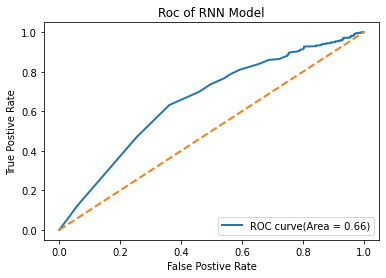

In [105]:
plt.figure()
plt.plot(FP_rate[0],TP_rate[0],lw=2,label='ROC curve(Area = %0.2f)'%ROC1[0])
plt.plot([0,1],[0,1],lw=2,linestyle='--')
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('Roc of RNN Model')
plt.legend(loc='lower right')
plt.show()

In [106]:
FP_rate =dict()
TP_rate = dict()
ROC1 = dict()
for i in range(2):
  FP_rate[i],TP_rate[i],_ = roc_curve(y_test[:,i],cnn_predict[:,i])
  ROC1[i] = auc(FP_rate[i],TP_rate[i])

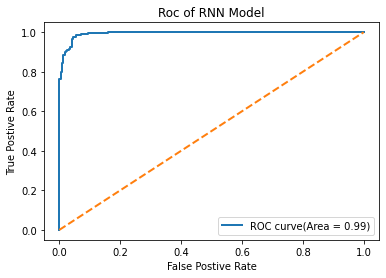

In [107]:
plt.figure()
plt.plot(FP_rate[0],TP_rate[0],lw=2,label='ROC curve(Area = %0.2f)'%ROC1[0])
plt.plot([0,1],[0,1],lw=2,linestyle='--')
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('Roc of RNN Model')
plt.legend(loc='lower right')
plt.show()